In [34]:
# import all library
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [35]:
#explore the data
df=pd.read_csv('/content/TSLA.csv', parse_dates=True , index_col="Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


# Data visualization

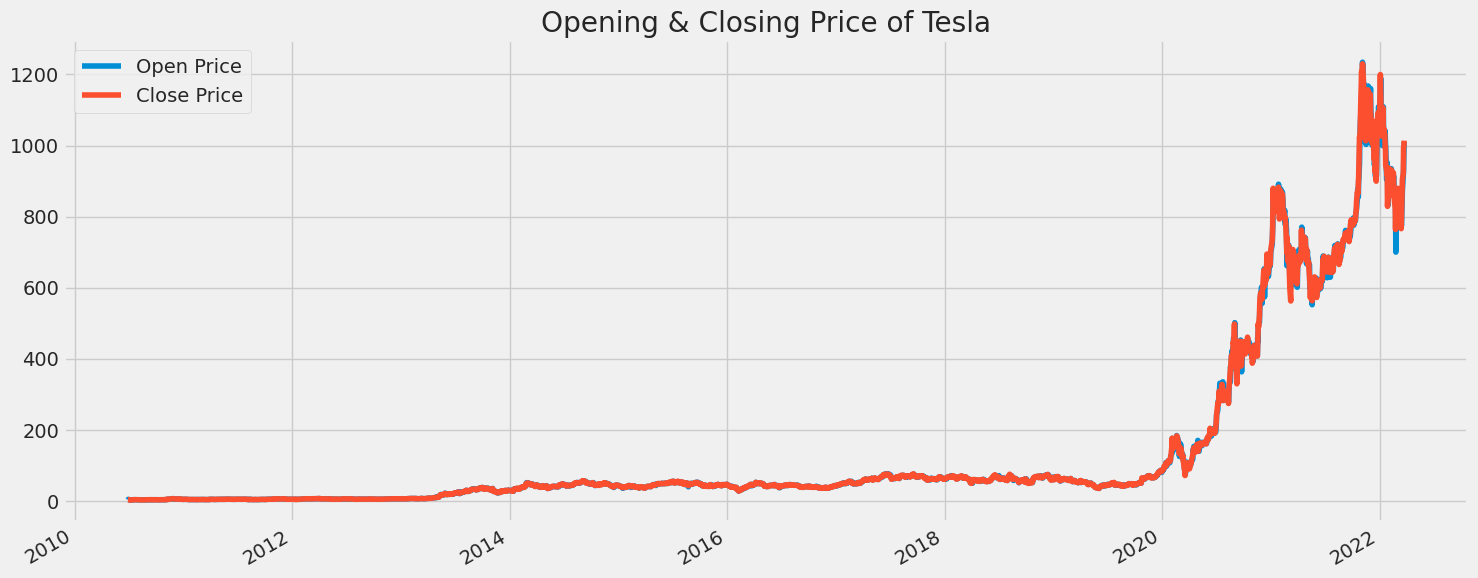

In [37]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

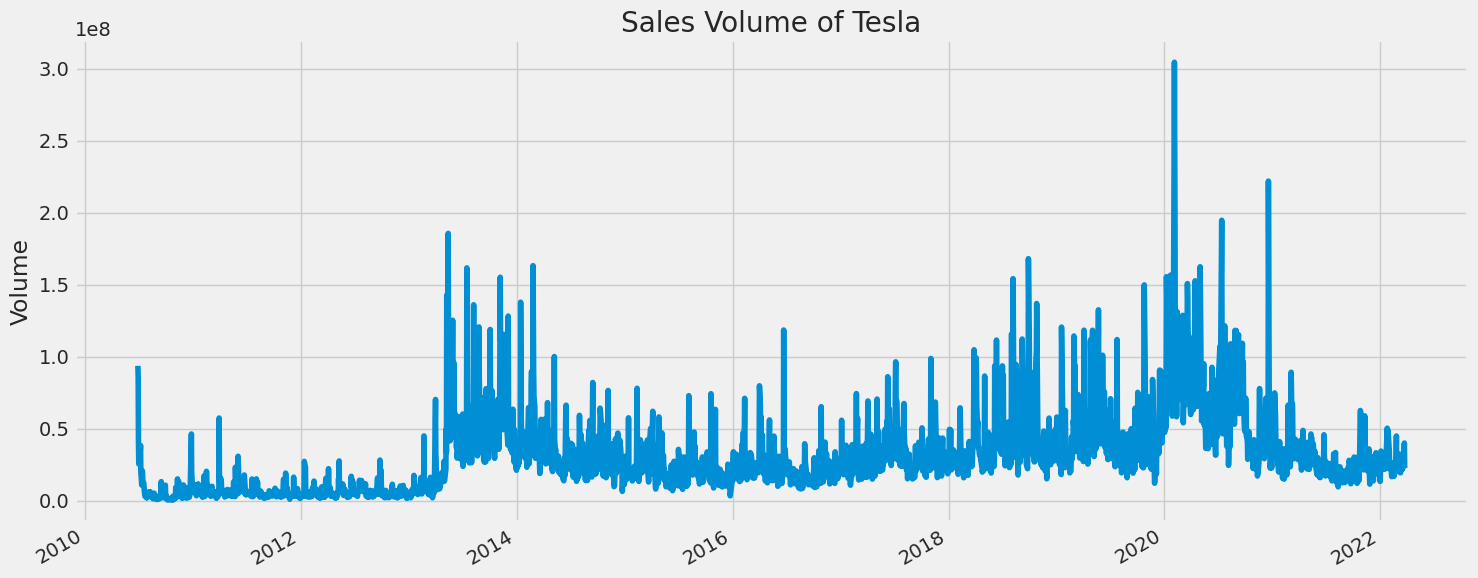

In [38]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

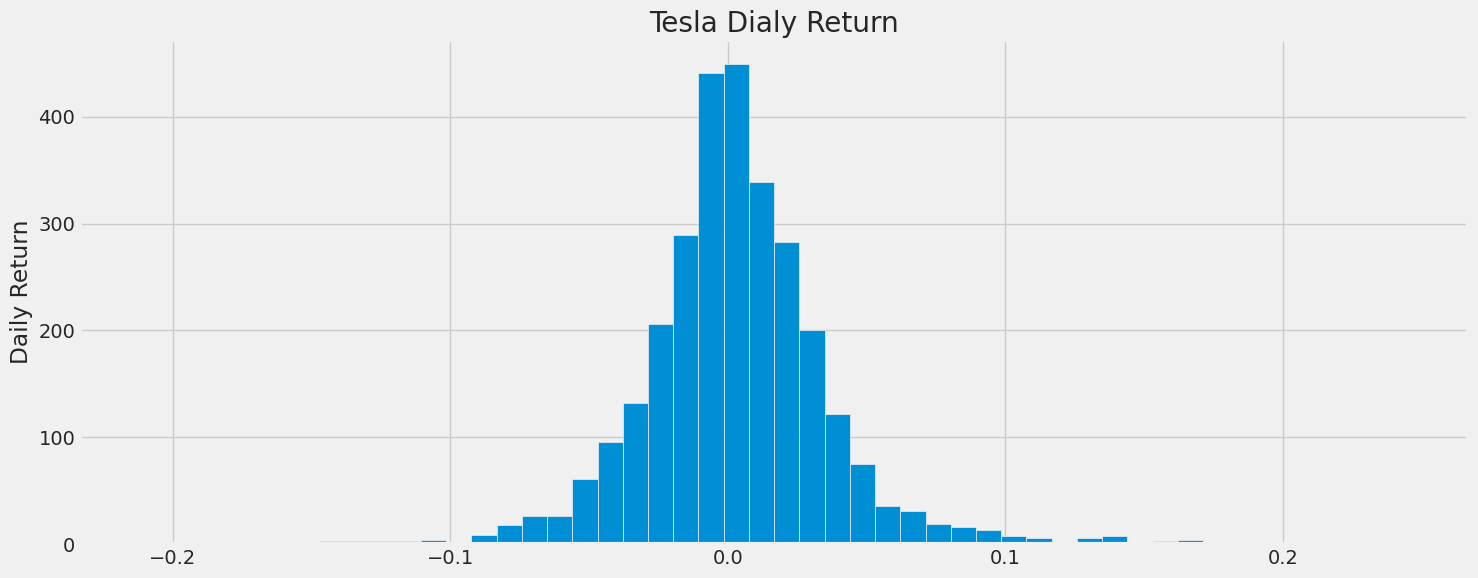

In [39]:
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessin

In [40]:
dataset = df["Close"]  #Choosing Prediction Column
dataset = pd.DataFrame(dataset)
#dataset
data = dataset.values
data.shape

(2956, 1)

In [41]:
dataset

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


Normalizing Data

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [43]:
data

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

Splitting the Data

In [44]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75) # the train sixze is 75% of all data
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]  # train size = 2217
test_data = scaled_data[ train_size-60: , 0:1 ] # 60 is time step to link data with each onthers to keep the sequence

Train Size : 2217 Test Size : 739


In [45]:
train_data.shape, test_data.shape

((2217, 1), (799, 1))

Creating training set

In [46]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [47]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [48]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [49]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

In [50]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 [==============================] - 8s 56ms/step - loss: 1.0518e-04 - mean_absolute_error: 0.0063
Epoch 2/100
68/68 [==============================] - 5s 79ms/step - loss: 5.3047e-06 - mean_absolute_error: 0.0017
Epoch 3/100
68/68 [==============================] - 4s 57ms/step - loss: 5.2602e-06 - mean_absolute_error: 0.0017
Epoch 4/100
68/68 [==============================] - 4s 57ms/step - loss: 5.6335e-06 - mean_absolute_error: 0.0018
Epoch 5/100
68/68 [==============================] - 6s 92ms/step - loss: 4.7126e-06 - mean_absolute_error: 0.0015
Epoch 6/100
68/68 [==============================] - 4s 62ms/step - loss: 4.8743e-06 - mean_absolute_error: 0.0016
Epoch 7/100
68/68 [==============================] - 4s 58ms/step - loss: 4.7007e-06 - mean_absolute_error: 0.0016
Epoch 8/100
68/68 [==============================] - 4s 65ms/step - loss: 4.7700e-06 - mean_absolute_error: 0.0016
Epoch 9/100
68/68 [==============================] - 5s 68ms/step - loss: 4.6258

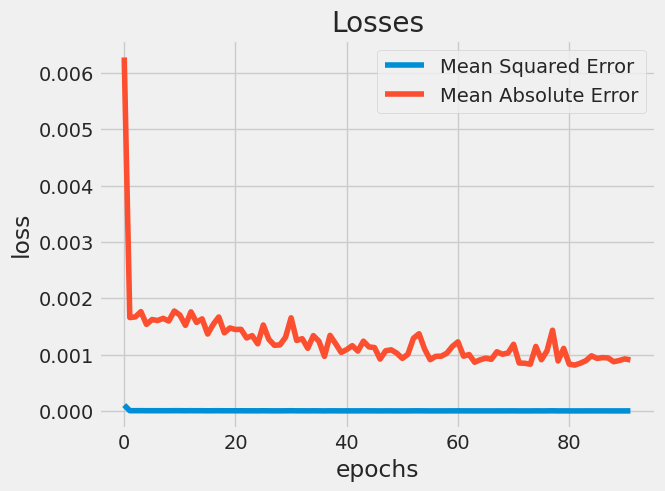

In [53]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [54]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [55]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [56]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 [==============================] - 1s 17ms/step


(739, 1)

In [57]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

26.33

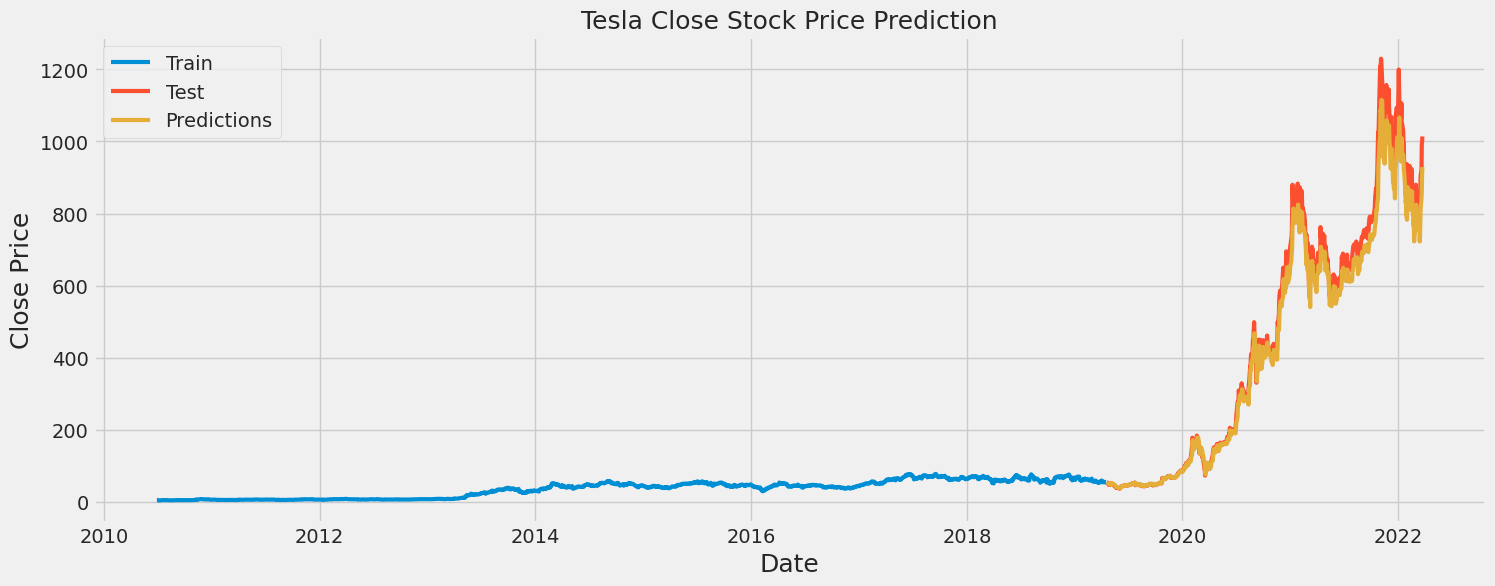

In [58]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])


In [59]:
from datetime import timedelta
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [60]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))
time

1/1 [==============================] - 0s 26ms/step
[0.7545897]
1/1 [==============================] - 0s 27ms/step
[0.7545897, 0.7145052]
1/1 [==============================] - 0s 25ms/step
[0.7545897, 0.7145052, 0.6683983]
1/1 [==============================] - 0s 36ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686]
1/1 [==============================] - 0s 27ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686, 0.58313787]
1/1 [==============================] - 0s 25ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686, 0.58313787, 0.5478005]
1/1 [==============================] - 0s 26ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686, 0.58313787, 0.5478005, 0.517732]
1/1 [==============================] - 0s 26ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686, 0.58313787, 0.5478005, 0.517732, 0.49237323]
1/1 [==============================] - 0s 26ms/step
[0.7545897, 0.7145052, 0.6683983, 0.62369686, 0.58313787, 0.5478005, 0.517732, 0.49237323, 0.47089377]
1/1 [============

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

In [61]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)


forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [62]:
df_result

,Date,Forecasted
0,2022-03-24,928.852966
1,2022-03-25,879.679321
2,2022-03-26,823.117676
3,2022-03-27,768.280151
4,2022-03-28,718.524414
5,2022-03-29,675.174316
6,2022-03-30,638.287781
7,2022-03-31,607.178894
8,2022-04-01,580.828918
9,2022-04-02,558.171448


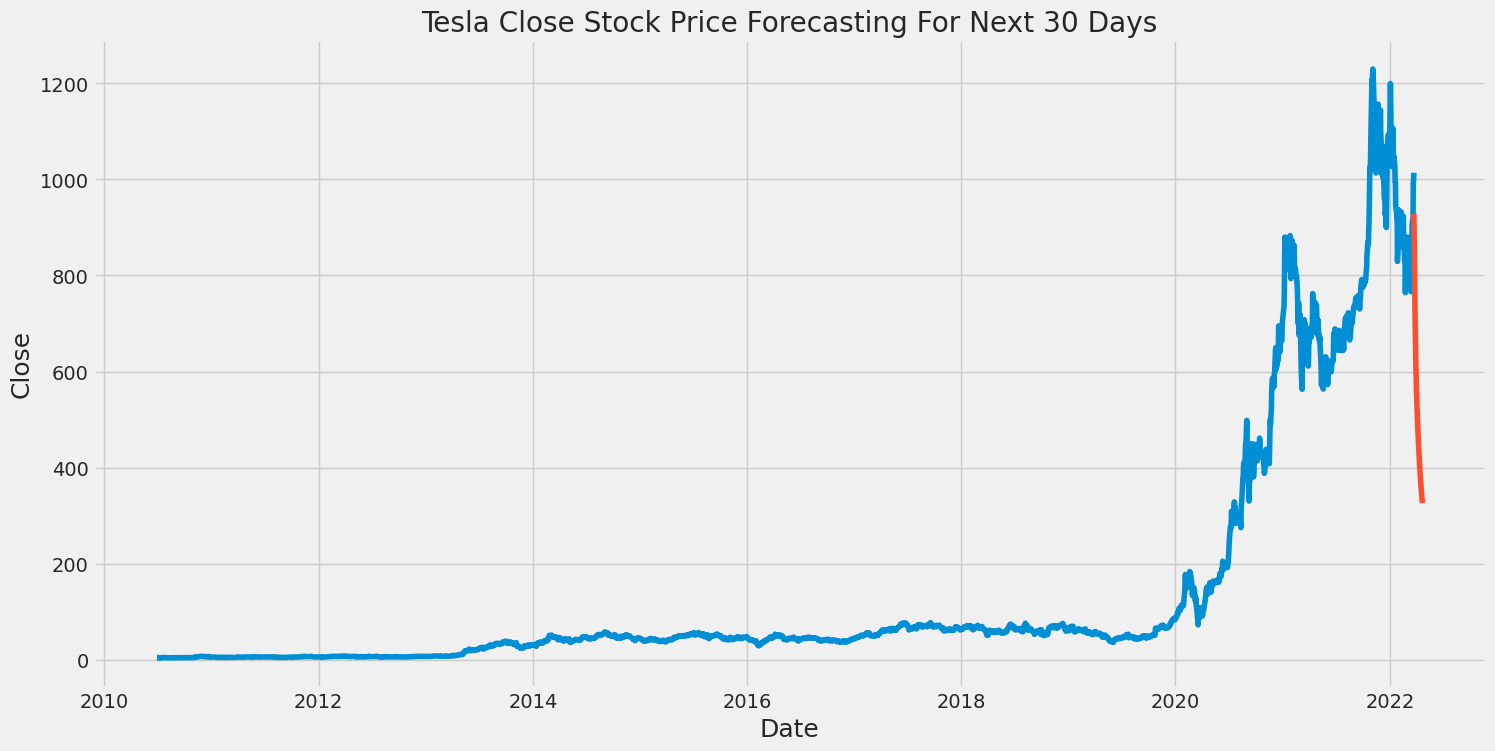

In [63]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])